In [1]:
import glob
import time
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import PIL
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
%matplotlib inline


In [2]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
# importing training data
base_dir = "C:/Users/wobojog/Desktop/vichel detection/"
GTI_far = glob.glob(base_dir+"vehicles/GTI_Far/*.png")
GTI_left =  glob.glob(base_dir+"vehicles/GTI_left/*.png")
GTI_right =  glob.glob(base_dir+"vehicles/GTI_right/*.png")
GTI_middleclose =  glob.glob(base_dir+"vehicles/GTI_MiddleClose/*.png")
KITTI_extracted =  glob.glob(base_dir+"vehicles/KITTI_extracted/*.png")
all_cars = GTI_far + GTI_left + GTI_right + GTI_middleclose + KITTI_extracted

GTI = glob.glob(base_dir+"non-vehicles/GTI/*.png")
extras = glob.glob(base_dir+"non-vehicles/Extras/*.png")
all_notcars = GTI + extras

print('Number of images in cars set = ', len(all_cars))
print('Number of images in not_cars set = ', len(all_notcars))

Number of images in cars set =  8792
Number of images in not_cars set =  8968


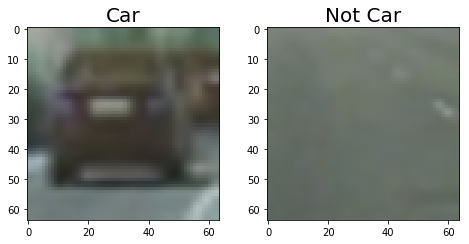

In [4]:
def plot_car_notcar(image1, image2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title("Car", fontsize=20)
    ax2.imshow(image2)
    ax2.set_title("Not Car", fontsize=20)
    plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)
        
plot_car_notcar(cv2.imread(all_cars[0]), cv2.imread(all_notcars[0]))

In [5]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

y_start = [400,400,410,420,430,430,440,400,400,500]
y_stop =  [500,500,500,555,555,555,555,555,555,555]
scale =   [1.0,1.3,1.4,1.6,1.8,2.0,1.9,1.3,2.2,3.0]

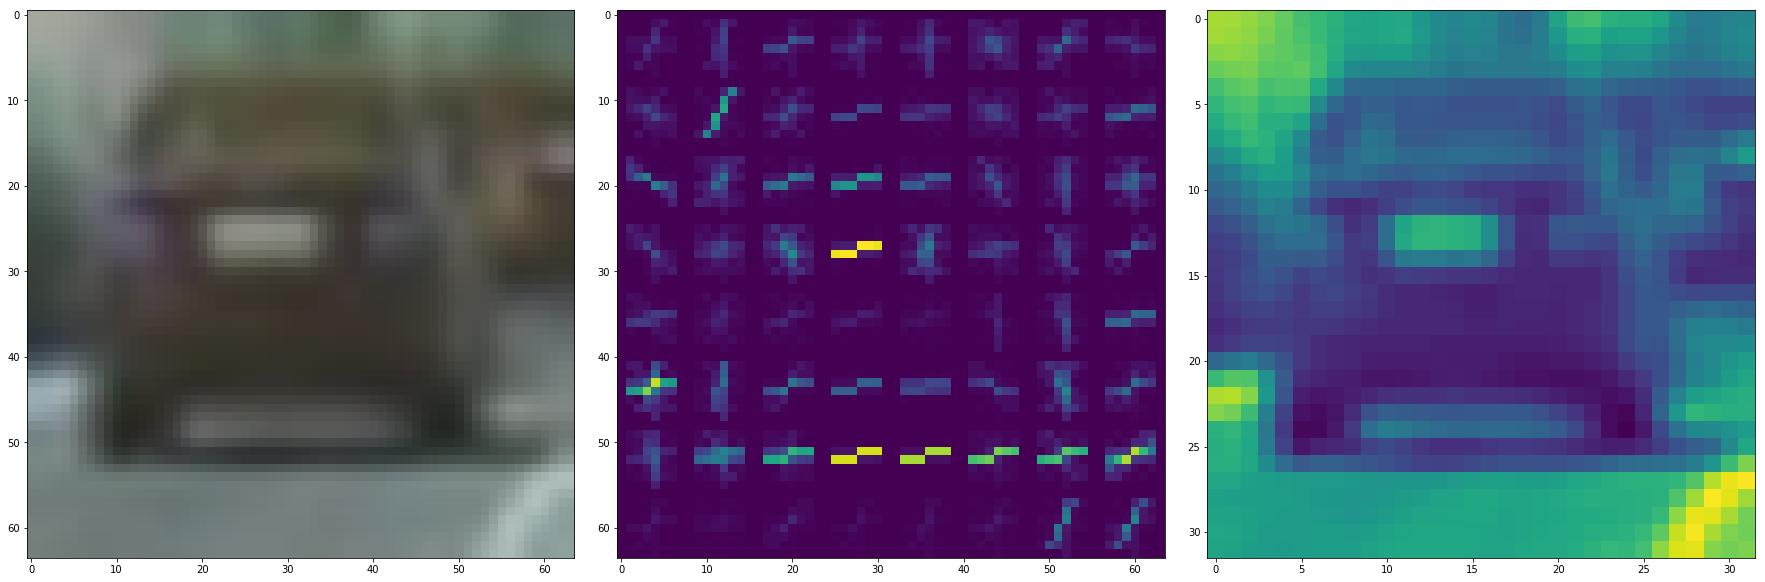

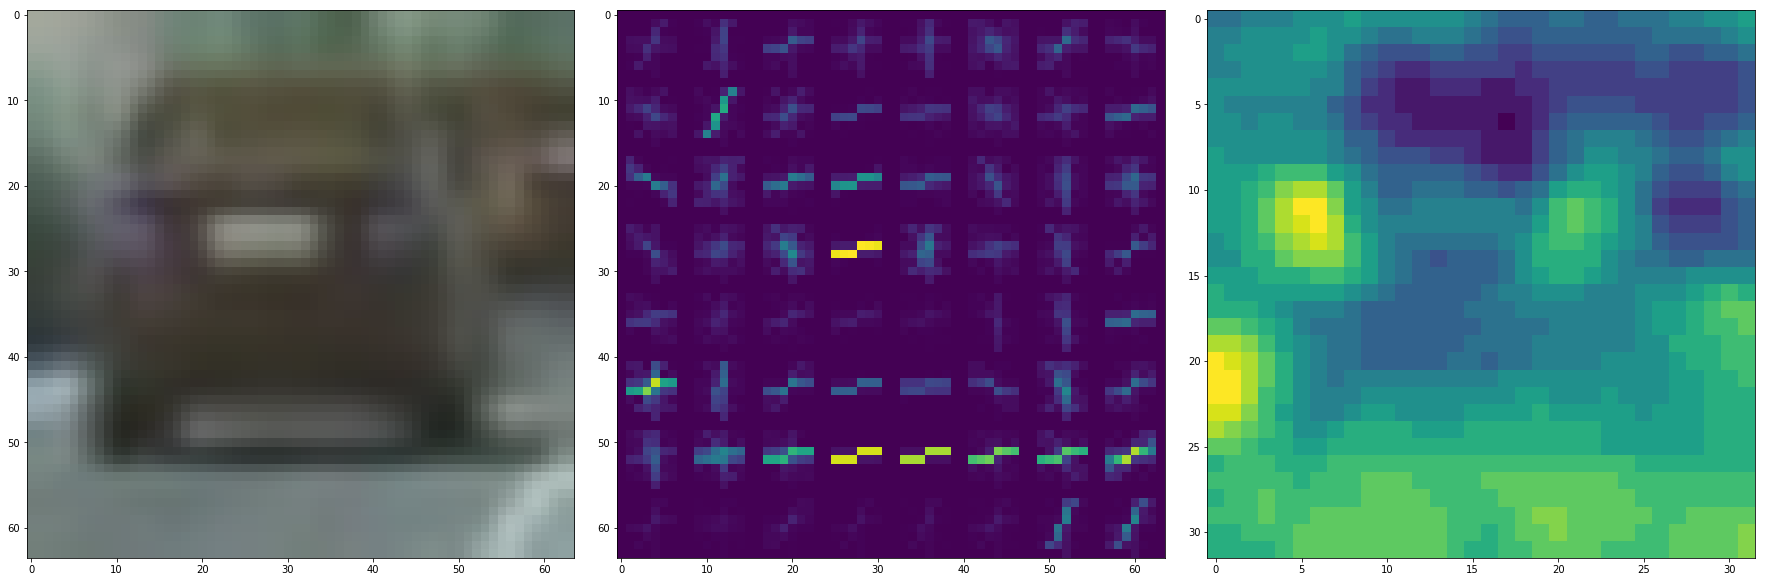

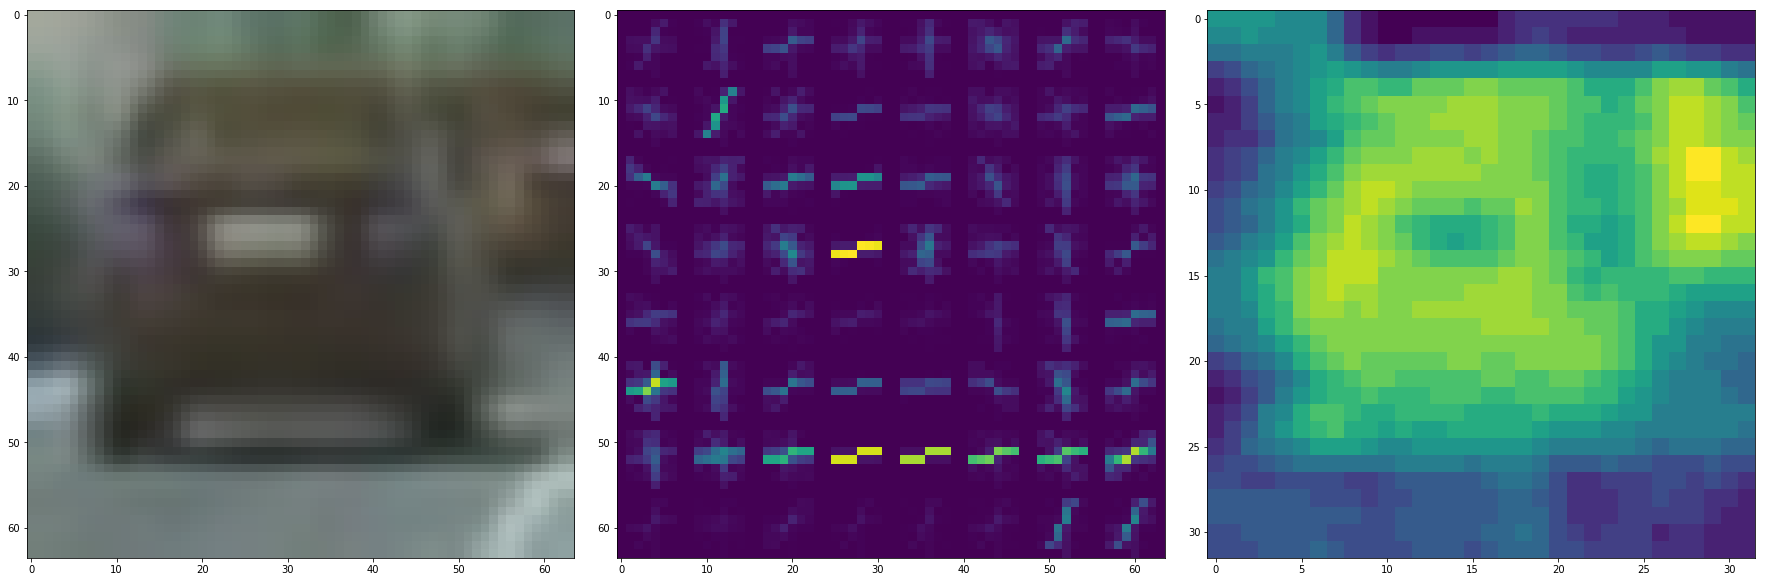

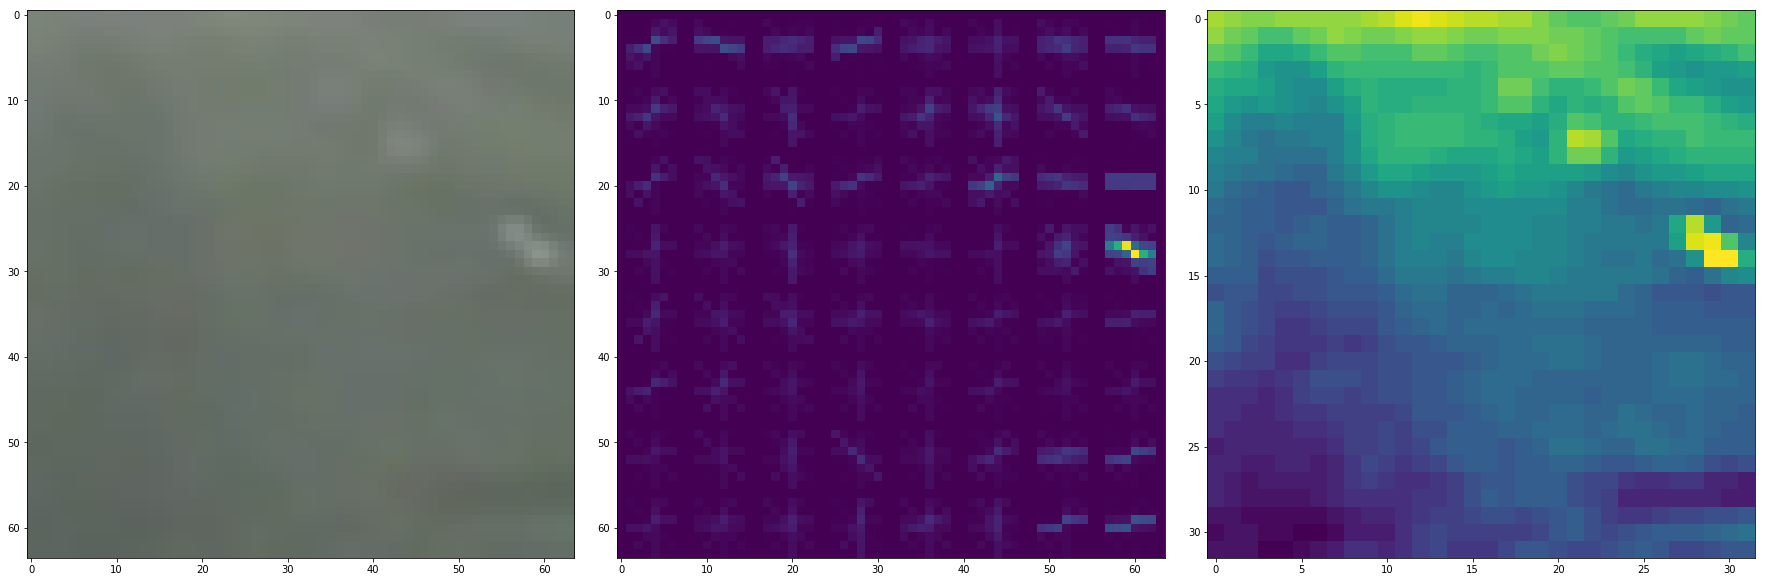

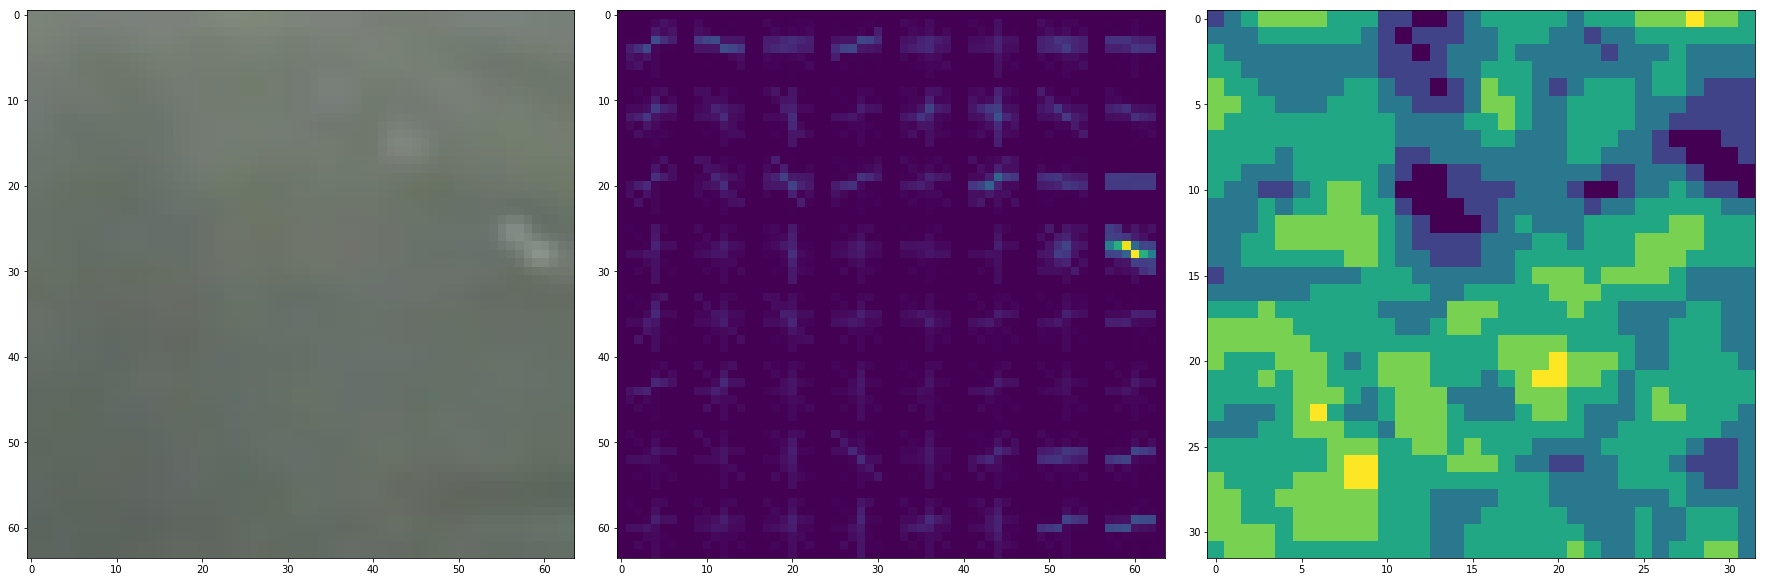

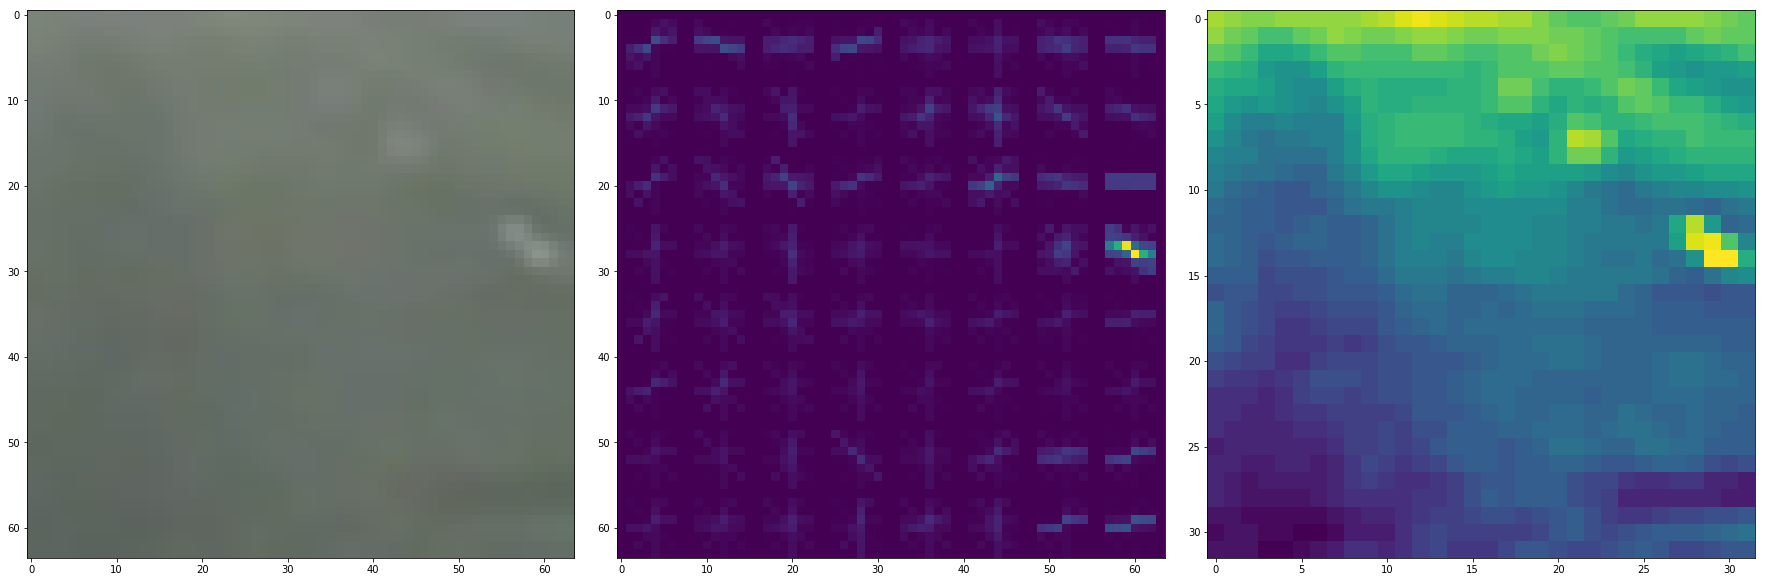

In [6]:
car_image = cv2.imread(all_cars[0])
notcar_image = cv2.imread(all_notcars[0])

converted_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
car_ch1 = converted_car_image[:,:,0]
car_ch2 = converted_car_image[:,:,1]
car_ch3 = converted_car_image[:,:,2]

converted_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YUV)
notcar_ch1 = converted_notcar_image[:,:,0]
notcar_ch2 = converted_notcar_image[:,:,1]
notcar_ch3 = converted_notcar_image[:,:,2]

car_hog_feature, car_hog_image = get_hog_features(car_ch1, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)

notcar_hog_feature, notcar_hog_image = get_hog_features(notcar_ch1, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)

car_ch1_features = cv2.resize(car_ch1, spatial_size)
car_ch2_features = cv2.resize(car_ch2, spatial_size)
car_ch3_features = cv2.resize(car_ch3, spatial_size)

notcar_ch1_features = cv2.resize(notcar_ch1, spatial_size)
notcar_ch2_features = cv2.resize(notcar_ch2, spatial_size)
notcar_ch3_features = cv2.resize(notcar_ch3, spatial_size)

def plot_image_hog_feature(image1, image2, image3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax2.imshow(image2)
    ax3.imshow(image3)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plot_image_hog_feature(car_image,car_hog_image,car_ch1_features)
plot_image_hog_feature(car_image,car_hog_image,car_ch2_features)
plot_image_hog_feature(car_image,car_hog_image,car_ch3_features)

plot_image_hog_feature(notcar_image,notcar_hog_image,notcar_ch1_features)
plot_image_hog_feature(notcar_image,notcar_hog_image,notcar_ch2_features)
plot_image_hog_feature(notcar_image,notcar_hog_image,notcar_ch1_features)

In [7]:
car_features = extract_features(all_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(all_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988
5.31 Seconds to train SVC...
Test Accuracy of SVC =  0.993


In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def find_cars(img, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[y_start:y_stop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+y_start)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+y_start))))

    return draw_img, bboxes


def sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    for i in range(len(y_start)):
        image, bbox = find_cars(image, y_start[i], y_stop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bbox)
    return image, bboxes

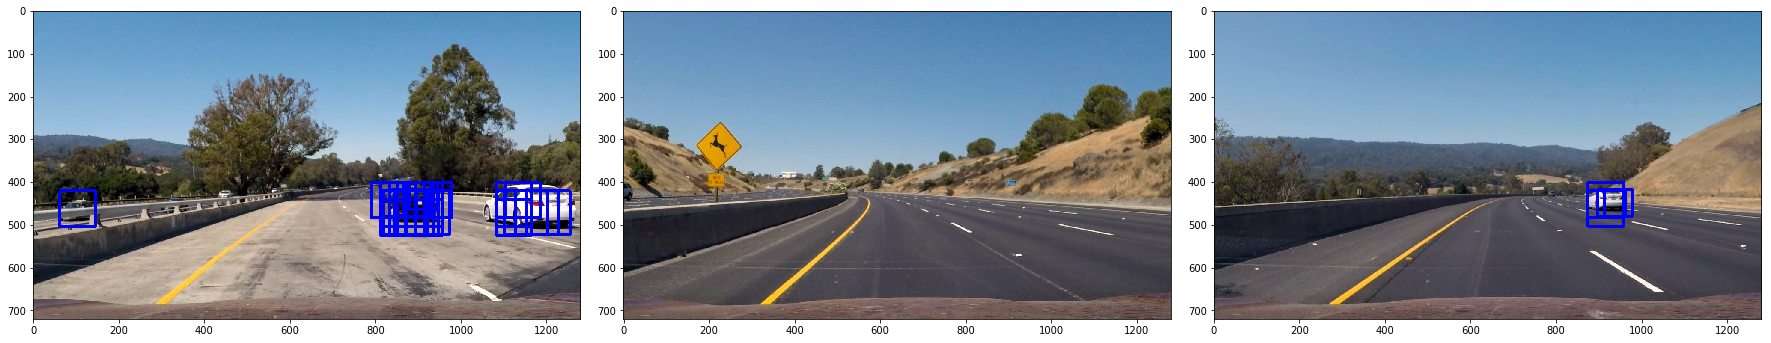

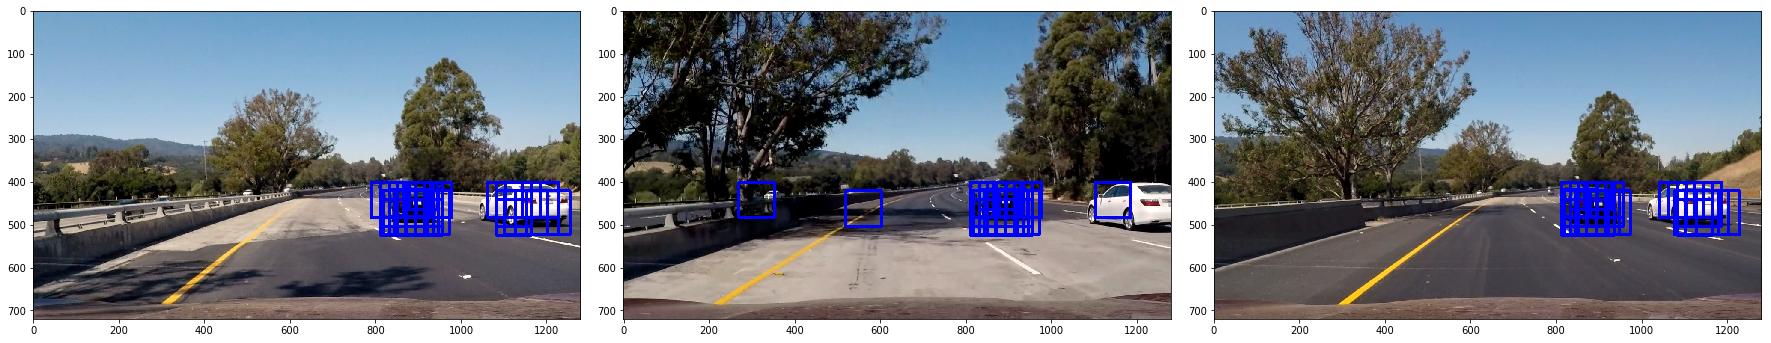

In [9]:
image1 = mpimg.imread('./test_images/test1.jpg')
image2 = mpimg.imread('./test_images/test2.jpg')
image3 = mpimg.imread('./test_images/test3.jpg')
image4 = mpimg.imread('./test_images/test4.jpg')
image5 = mpimg.imread('./test_images/test5.jpg')
image6 = mpimg.imread('./test_images/test6.jpg')

output_image1, bboxes1 = sliding_window(image1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image2, bboxes2 = sliding_window(image2, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image3, bboxes3 = sliding_window(image3, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image4, bboxes4 = sliding_window(image4, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image5, bboxes5 = sliding_window(image5, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image6, bboxes6 = sliding_window(image6, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

def plot_bboxes(image1, image2, image3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax2.imshow(image2)
    ax3.imshow(image3)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plot_bboxes(output_image1, output_image2, output_image3)
plot_bboxes(output_image4, output_image5, output_image6)

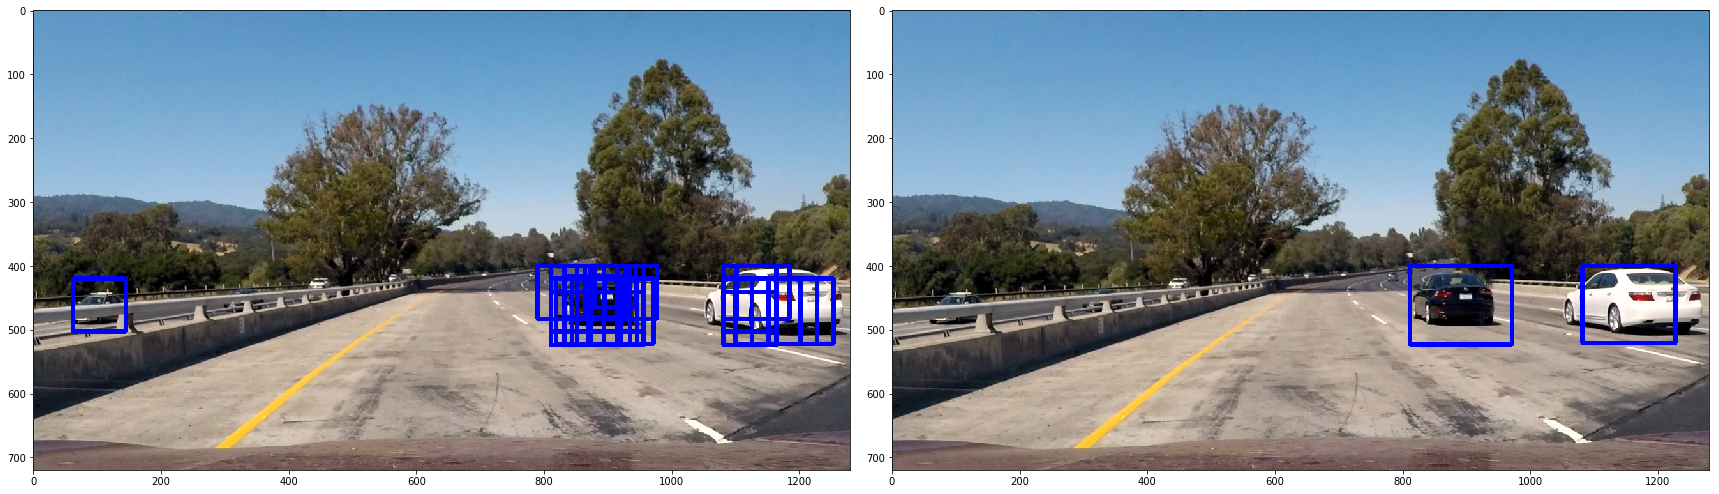

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


heat = np.zeros_like(output_image1[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, bboxes1)
    
# Apply threshold to help remove false positives
threshold = 1 
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image1), labels)

def plot_images_heatmaps(image1, image2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax2.imshow(image2, cmap='hot')
    
plot_images_heatmaps(output_image1, heatmap)
plt.imshow(draw_img)

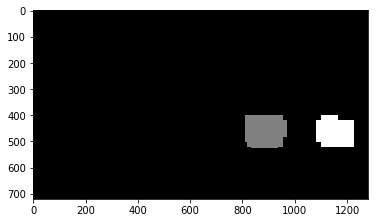

In [11]:
plt.imshow(labels[0], cmap='gray')

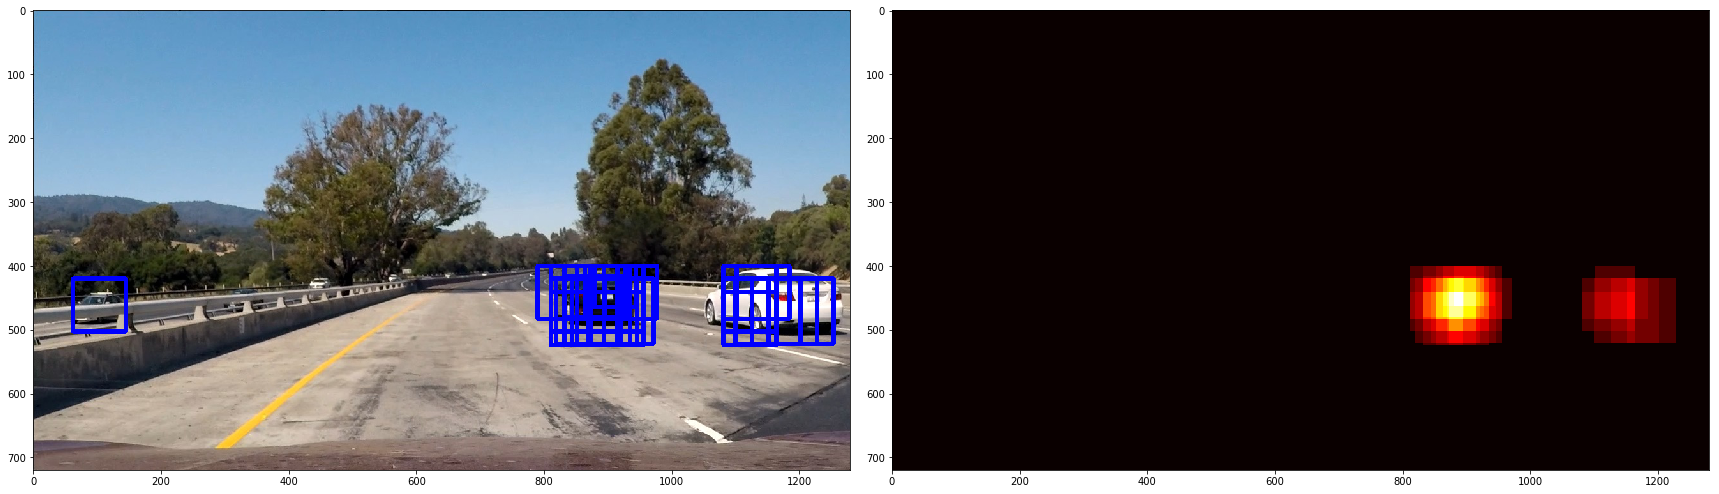

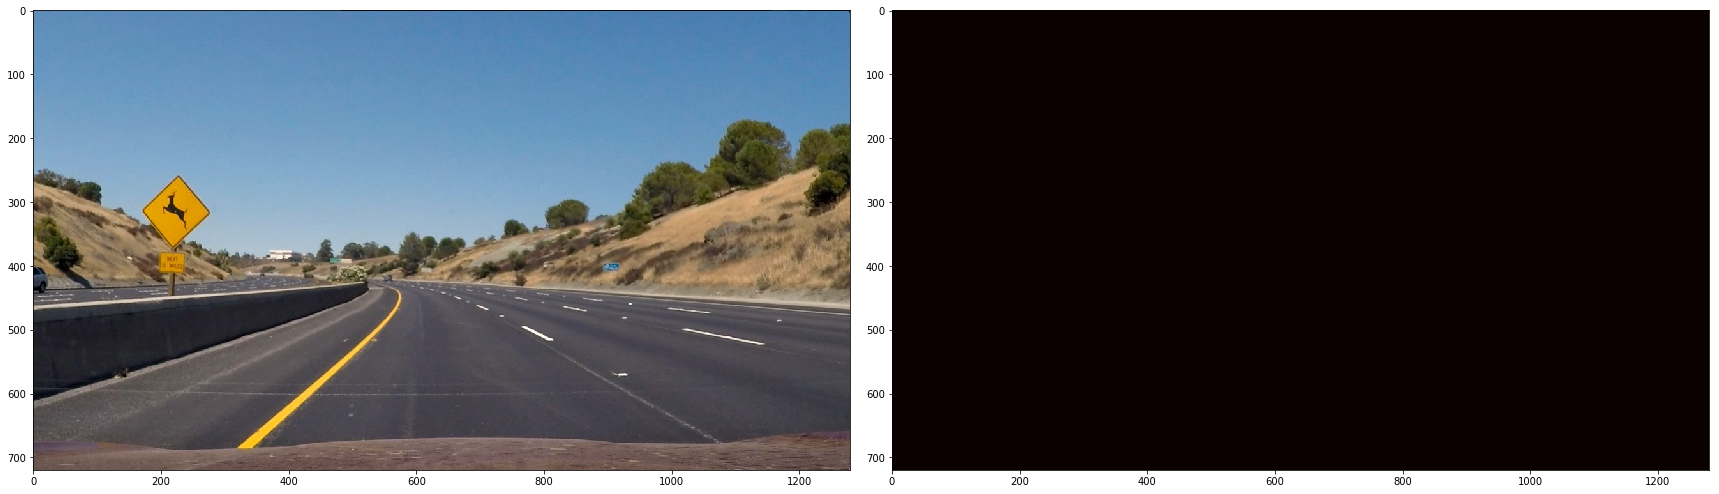

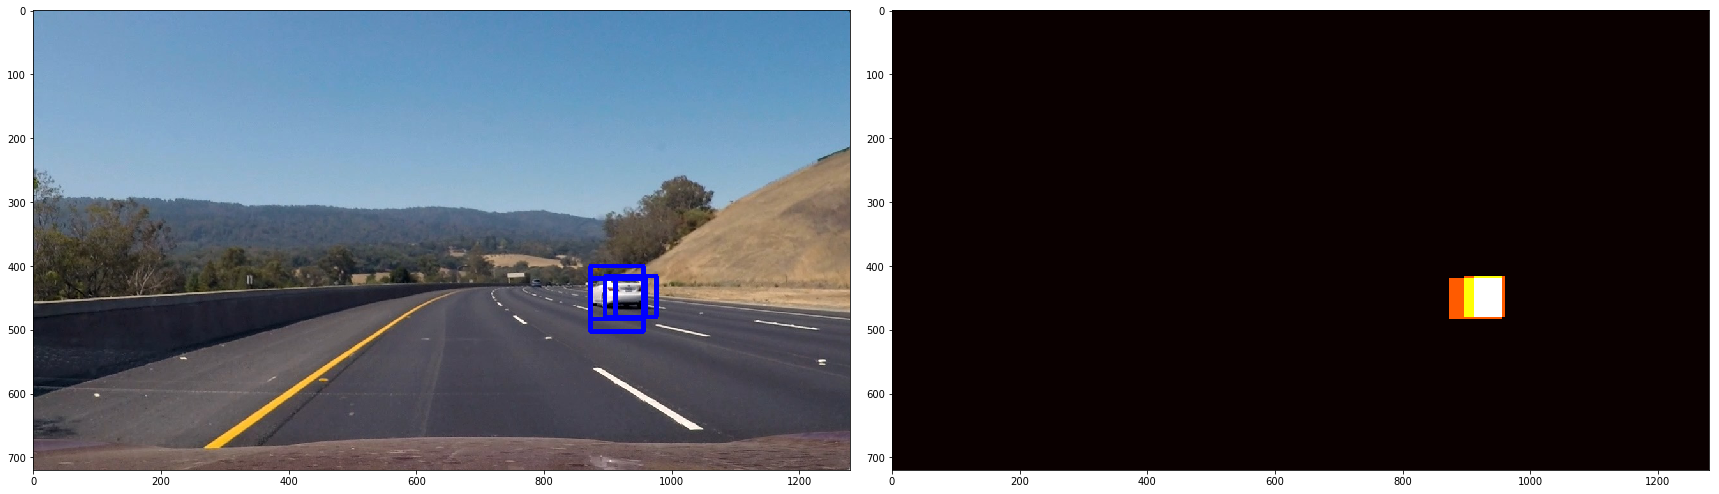

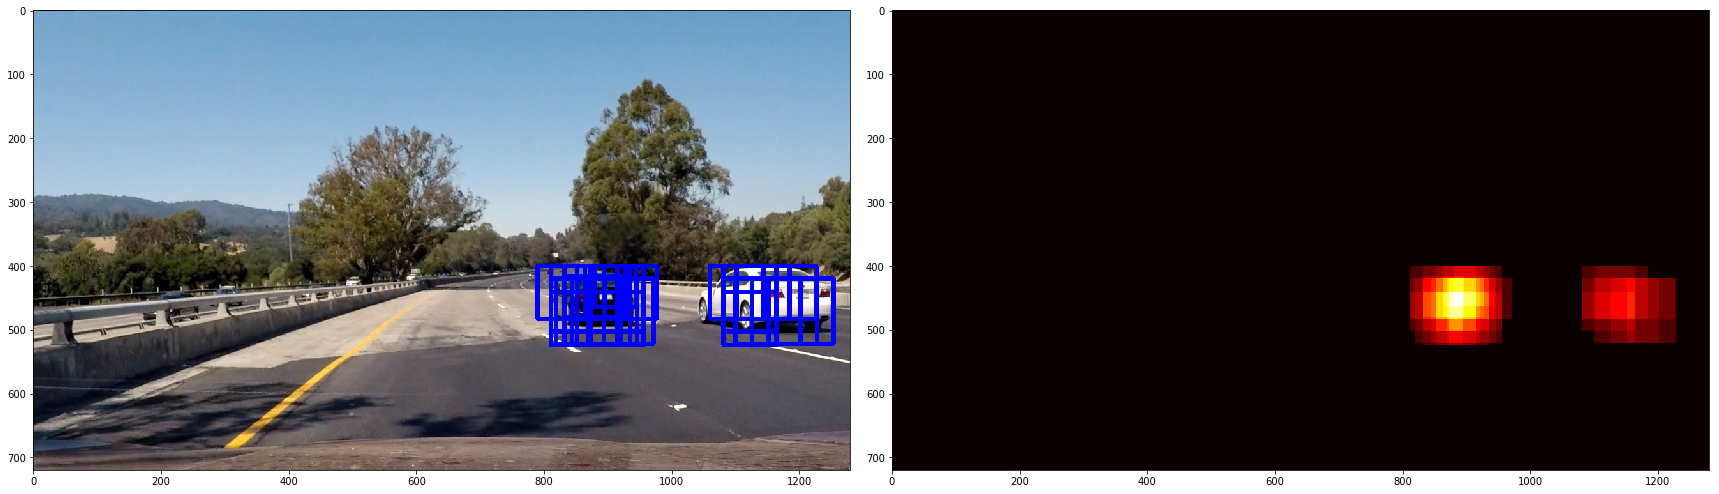

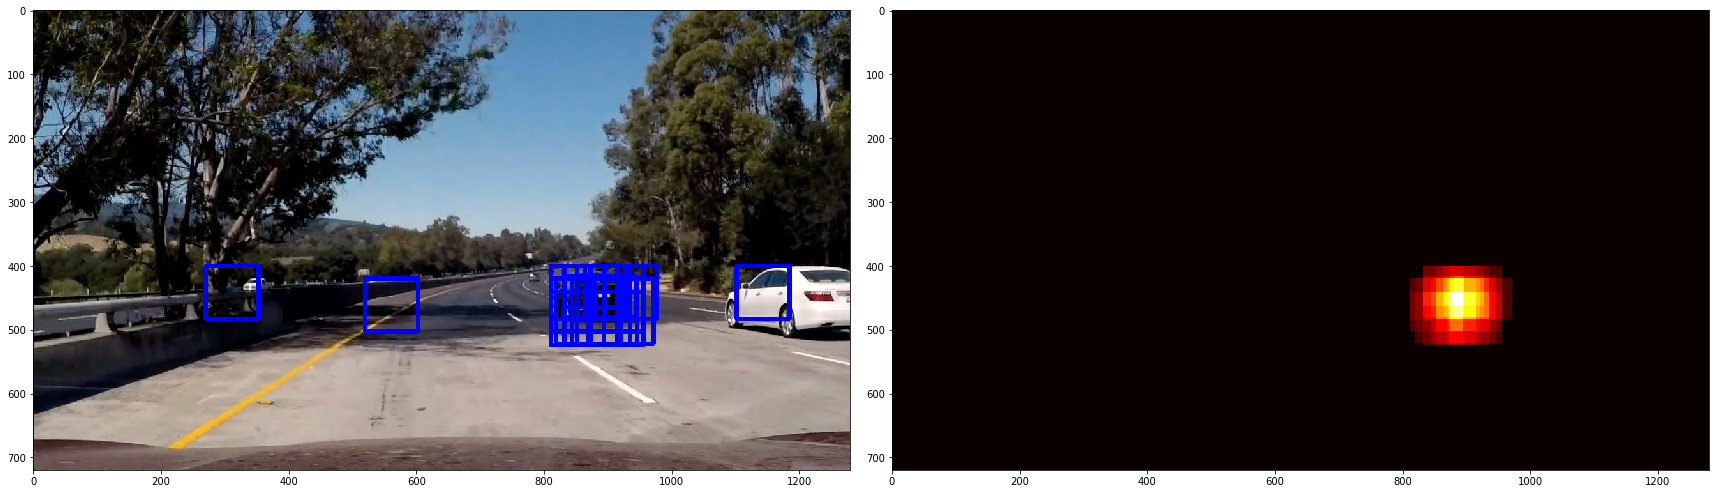

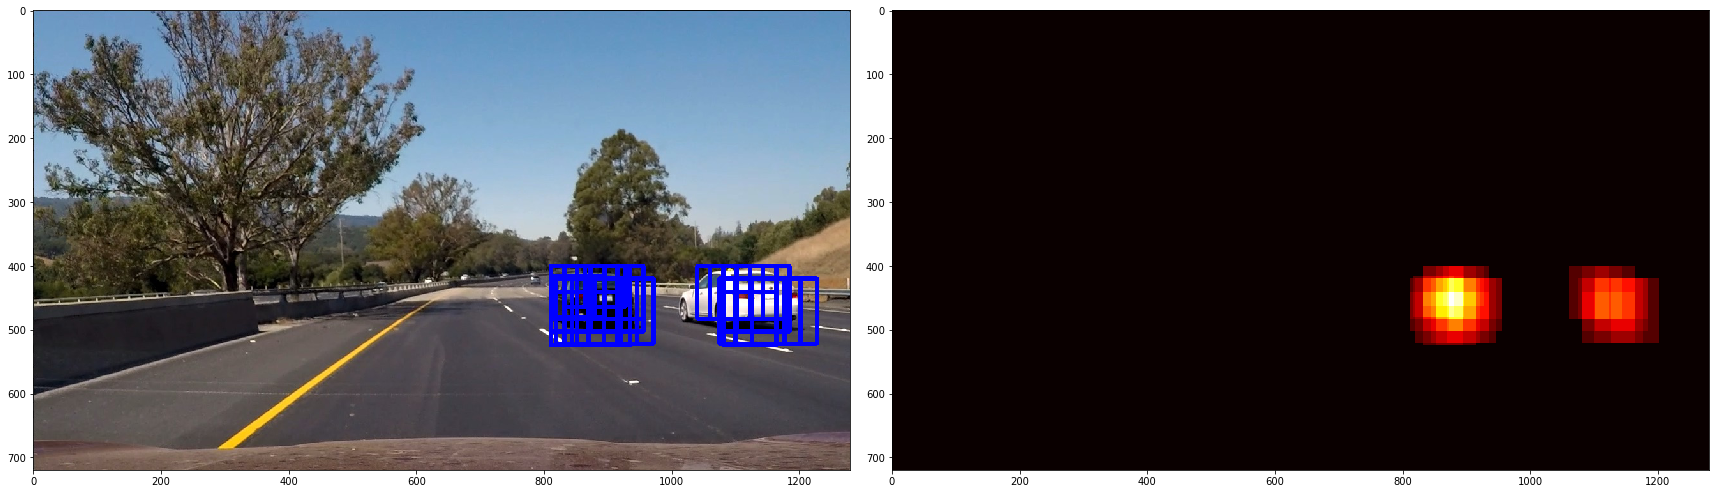

In [12]:
def get_heatmap(bboxes):
    threshold = 1
    heat = np.zeros_like(output_image1[:,:,0]).astype(np.float) 
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

#def plot_images_heatmaps(image1, image2):
#    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#    f.tight_layout()
#    ax1.imshow(image1)
#    ax2.imshow(image2, cmap='hot')

heatmap1 = get_heatmap(bboxes1)
heatmap2 = get_heatmap(bboxes2)
heatmap3 = get_heatmap(bboxes3)
heatmap4 = get_heatmap(bboxes4)
heatmap5 = get_heatmap(bboxes5)
heatmap6 = get_heatmap(bboxes6)

plot_images_heatmaps(output_image1, heatmap1)
plot_images_heatmaps(output_image2, heatmap2)
plot_images_heatmaps(output_image3, heatmap3)
plot_images_heatmaps(output_image4, heatmap4)
plot_images_heatmaps(output_image5, heatmap5)
plot_images_heatmaps(output_image6, heatmap6)

In [13]:
history = deque(maxlen = 25)

def pipe_line(image):
    
    bboxes = []
    for i in range(len(y_start)):
        out_img, bbox = find_cars(image, y_start[i], y_stop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bbox)

    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    threshold = 1 
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    
# img = pipe_line(image1)
# plt.imshow(img)


In [14]:
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(pipe_line)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:35<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 14min 36s
